## Projectile trajectory optimization via automatic differentiation torch-style

Here we first create primitive classes akin to torch's Tensor and Function, which record computation graph and later use it to compute gradients. Then we test them on a classical projectile motion simulation. We do the simulation, compute distance, calculate error wrt to our target distance and then differentiate the whole simulation to get the gradients of our params - initial projectile speed and angle. Based on gradients we then update the params to minimize the error until we get close enough to target.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class Fn:
    def __call__(self,*args):
        res=self.forward(*args)
        if Tensor.do_grad:
            self.args=args
            do_grad=sum([isinstance(a,Tensor) and a.do_grad for a in args])>0
            res.do_grad=do_grad
            res.fn=self if do_grad else None
        return res
    
    def _backward(self,grad):
        return self.backward(grad,*self.args)

class NegFn(Fn):
    def forward(self,x): return Tensor(-Tensor.strip(x))
    def backward(self,grad,x): return [-grad]
    
class AddFn(Fn):
    def forward(self,x,y): return Tensor(Tensor.strip(x)+Tensor.strip(y))
    def backward(self,grad,x,y): return [grad,grad]
    
class SubFn(Fn):
    def forward(self,x,y): return Tensor(Tensor.strip(x)-Tensor.strip(y))
    def backward(self,grad,x,y): return [grad,-grad]
    
class MulFn(Fn):
    def forward(self,x,y): return Tensor(Tensor.strip(x)*Tensor.strip(y))
    def backward(self,grad,x,y): return [grad*y,grad*x]
    
class DivFn(Fn):
    def forward(self,x,y): return Tensor(Tensor.strip(x)/Tensor.strip(y))
    def backward(self,grad,x,y): return [grad/y,-grad*x/y**2.]
    
class PowFn(Fn):
    def forward(self,x,y): return Tensor(Tensor.strip(x)**Tensor.strip(y))
    @np.errstate(invalid='ignore') # don't show warning for neg log argument, just return nan
    def backward(self,grad,x,y): return [grad*y*x**(y-1.),grad*x**y*Tensor.log(x)]
    
class CosFn(Fn):
    def forward(self,x): return Tensor(np.cos(Tensor.strip(x)))
    def backward(self,grad,x): return [-grad*x.sin()]
    
class SinFn(Fn):
    def forward(self,x): return Tensor(np.sin(Tensor.strip(x)))
    def backward(self,grad,x): return [grad*x.cos()]
    
class SumFn(Fn):
    def forward(self,x): return Tensor(np.sum(Tensor.strip(x)))
    def backward(self,grad,x): return [grad*Tensor.ones(x.shape)]
    
class GetItemFn(Fn):
    def forward(self,x,key): return Tensor(Tensor.strip(x)[key])
    def backward(self,grad,x,key):
        out=Tensor.zeros(x.shape)
        out[key]=grad
        return [out,0.] # grad for `key' argument is 0

In [5]:
class Tensor:
    do_grad=True
    
    def __init__(self,v,do_grad=False,fn=None):
        self.v=np.array(Tensor.strip(v))
        self.do_grad=do_grad
        self._grad=None
        self.fn=fn

    @staticmethod
    def strip(t):
        try:
            iter(t)
        except TypeError:
            return t.v if isinstance(t,Tensor) else t
        return np.array([el.v if isinstance(el,Tensor) else el for el in t])

    def __neg__(self): return NegFn()(self)
    def __mul__(self,other): return MulFn()(self,other)
    def __rmul__(self,other): return MulFn()(self,other)
    def __truediv__(self,other): return DivFn()(self,other)
    def __rtruediv__(self,other): return DivFn()(other,self)
    def __add__(self,other): return AddFn()(self,other)
    def __radd__(self,other): return AddFn()(self,other)
    def __sub__(self,other): return SubFn()(self,other)
    def __rsub__(self,other): return SubFn()(other,self)
    def __isub__(self,other):
        if self.do_grad and Tensor.do_grad:
            raise TypeError('in-place operation is prohibited, since it may change the graph')
        self.v=SubFn()(self,other).v
        return self

    def __pow__(self,other): return PowFn()(self,other)
    def __rpow__(self,other): return PowFn()(other,self)

    def __le__(self,other): return Tensor(self.v<=Tensor.strip(other))
    def __lt__(self,other): return Tensor(self.v<Tensor.strip(other))
    def __bool__(self): return bool(self.v)
    
    def __repr__(self):
        r=repr(self.v).replace('array','tensor')
        if self.fn:
            r=r[:-1]+f', fn=<{self.fn.__class__.__name__}>)'
        return r
    
    def __getitem__(self,key): return GetItemFn()(self,key)
    def __setitem__(self,key,val): self.v[key]=Tensor.strip(val)
    def __iter__(self): return iter(self.v)
    
    def cos(self): return CosFn()(self)
    def sin(self): return SinFn()(self)
    def sqrt(self): return PowFn()(self,.5)
    def sum(self): return SumFn()(self)
    
    def zero_(self):
        if self.do_grad and Tensor.do_grad:
            raise TypeError('in-place operation is prohibited, since it may change the graph')
        self.v=Tensor.zeros(self.shape).v
        return self
    
    @staticmethod
    def zeros(shape): return Tensor(np.zeros(shape))
    @staticmethod
    def ones(shape): return Tensor(np.ones(shape))
    @staticmethod
    def log(t): return Tensor(np.log(Tensor.strip(t)))
        
    class no_grad:
        def __enter__(self):
            Tensor.do_grad=False
        def __exit__(self,*args):
            Tensor.do_grad=True

    def backward(self,create_graph=False):
        if not self.do_grad: raise TypeError("this tensor doesn't require gradients")
        lst=[(self,Tensor(1.))]
        with Tensor.no_grad():
            while lst:
                t,tgrad=lst.pop()
                if not t.fn or create_graph: # if leaf or saving grad to every node
                    if t.grad is None: t.grad=0.
                    if len(t.shape)==0 and len(tgrad.shape)>0:
                        # sum-reduce vector gradient for a scalar
                        t.grad+=tgrad.sum()
                    else:
                        t.grad+=tgrad

                if t.fn:
                    lst.extend([
                        (arg,grad)
                        for arg,grad in zip(t.fn.args,t.fn._backward(tgrad))
                        if isinstance(arg,Tensor) and arg.do_grad
                    ])

    @property
    def grad(self): return self._grad
    @grad.setter
    def grad(self,other): self._grad=other
    
    @property
    def shape(self): return self.v.shape

In [6]:
def fire(alpha,v0,tau=.1,trace=False):
    alpha=alpha*np.pi/180
    v=v0*(alpha.cos()*Tensor([1.,0.])+alpha.sin()*Tensor([0.,1.]))
    p=Tensor.zeros([2])
    g=Tensor([0.,-10.])
    t=0
    data=[]
    while True:
        v+=g*tau
        p+=v*tau
        if trace: data.append(p.v)
        t+=tau
        if p[1]<=0: break
    if trace: return p,t,np.array(data)
    return p,t

In [7]:
from time import time
alpha=Tensor(45.,do_grad=True)
v0=Tensor(65.,do_grad=True)
targ=105.
eps=.1
tau=.01 # simulation time-step
lr=.005
decay=.99 # lr decay
g=10.

tm=time()
simtm=0
steps=[]
for i in range(100):
    print('****************************************************************************')
    print(alpha,v0)
    p,t=fire(alpha,v0,tau)
    simtm+=t
    dist,height=p[0],p[1]
    err=(targ-dist)**2
    steps.append((alpha.v,v0.v,err.v))
    print(round(t,1),height,dist,err.sqrt())
    err.backward()
    print(alpha.grad,v0.grad)
    if err.sqrt()<eps: break
    with Tensor.no_grad():
        alpha-=lr*alpha.grad
        v0-=lr*v0.grad
        alpha.grad.zero_()
        v0.grad.zero_()
    lr*=decay
steps=np.array(steps)
print('============================================================================')
print(i+1,'iters',round(time()-tm,1),'s',round(simtm,2),'s simulated',
      round(simtm/tau),'sim cycles')

****************************************************************************
tensor(45.) tensor(65.)
9.2 tensor(-0.34976426, fn=<GetItemFn>) tensor(422.39023574, fn=<GetItemFn>) tensor(317.39023574, fn=<PowFn>)
tensor(-4679.6653309) tensor(4125.00112299)
****************************************************************************
tensor(68.39832665) tensor(44.37499439)
8.2 tensor(-0.34361879, fn=<GetItemFn>) tensor(134.77802193, fn=<GetItemFn>) tensor(29.77802193, fn=<PowFn>)
tensor(-353.80910503) tensor(180.88668851)
****************************************************************************
tensor(70.14968172) tensor(43.47960528)
8.2 tensor(-0.03125771, fn=<GetItemFn>) tensor(120.62279973, fn=<GetItemFn>) tensor(15.62279973, fn=<PowFn>)
tensor(-182.20947898) tensor(86.68274845)
****************************************************************************
tensor(71.04259928) tensor(43.05481647)
8.1 tensor(-0.2479501, fn=<GetItemFn>) tensor(113.85422986, fn=<GetItemFn>) tensor(8.854229

In [8]:
def dist_analyt(alpha,v0): return v0**2*np.sin(2*alpha*np.pi/180)/g
dist_analyt(72.21851664,42.52804207)

105.18968595440342

analytical distance differs a bit, since in simulation we stop at height~-0.029 instead of 0

tensor([ 1.05069166e+02, -2.91381275e-02])


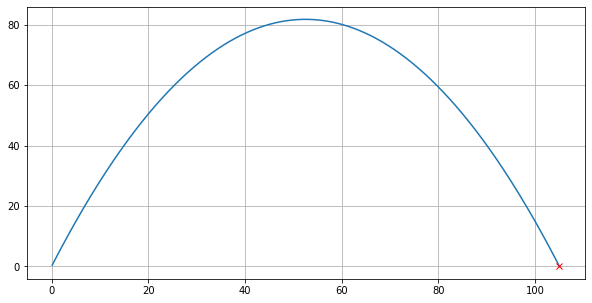

In [9]:
with Tensor.no_grad():
    p,t,data=fire(alpha,v0,tau,trace=True)
print(p)
plt.figure(figsize=(10,5))
plt.plot(data[:,0],data[:,1])
plt.plot(targ,0,'rx')
plt.grid()

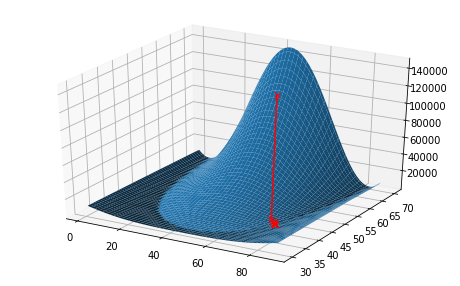

In [10]:
n=100
g=10.
alphas=np.linspace(1,89,n)
v0s=np.linspace(30,70,n)
alphas,v0s=np.meshgrid(alphas,v0s)
errors=(targ-dist_analyt(alphas,v0s))**2

import mpl_toolkits.mplot3d
# %matplotlib notebook #interactive mode
ax=plt.figure(figsize=(8,5)).add_subplot(111,projection='3d')
ax.plot_surface(alphas,v0s,errors,zorder=-10) # plot analytical error surface
ax.plot(steps[:,0],steps[:,1],steps[:,2],'r-x',zorder=10) # plot simulation gradient descent

This is amazing at first: simulation gradient descent doesn't follow analytical function! At alpha=45 on first iteration the gradient must point up the hill, but it descends to the side. Below is the analytical gradient:

In [12]:
def grad_analyt(alpha,v0):
    return (2*(targ-v0**2*np.sin(np.pi/90*alpha)/g)
            *(-v0/g)
            *np.array([v0*np.cos(np.pi/90*alpha)*np.pi/90,np.sin(np.pi/90*alpha)*2]))

a,v=45.,65.
dist_analyt(a,v),(targ-dist_analyt(a,v))**2,grad_analyt(a,v)

(422.5, 100806.25, array([5.7344089e-13, 8.2550000e+03]))

Analytical grad points strictly up the hill at 45 alpha. Below is the simulation gradient at the same point. It deviates from analytical by nearly 45 degrees, which can be observed on 3d plot above.

In [13]:
at=Tensor(45.,do_grad=True)
vt=Tensor(65.,do_grad=True)
p,t=fire(at,vt,.01);print(p,t)
err=(targ-p[0])**2; print(err)
err.backward(create_graph=True)
at.grad,vt.grad

tensor([ 4.22390236e+02, -3.49764258e-01], fn=<AddFn>) 9.189999999999849
tensor(100736.56174422, fn=<PowFn>)


(tensor(-4679.6653309), tensor(4125.00112299))

This all happens because distance function that simulation ends up with is essentially a big sum of small movements along x axis, each tau \* v0_x. When summed up it equals total_time_of_flight \* v0_x - so the distance is arithmetically the same as in analytical function. But when differentiating analytical distance takes into account that total time of flight depends on alpha and v0, while simulation just sums small movements along x axis essentially treating time of flight as constant. Thus analytical and simulation distance functions are **different** and so is the gradient.

Nevertheless simulation distance func provides accurate judgement about the direction and magnitude of error letting us correctly update parameters, i.e. it just works!